In [1]:
import numpy as np
from pathlib import Path
import os, json
import matplotlib.pyplot as plt
cwd = Path.cwd()
import UPPtoolbox as upp
import seaborn as sns
from tqdm.notebook import tqdm
import warnings


# Important variables
SNRs = np.array([-np.inf,-13,-11,-9,-7,-5,-3])
SubIDs = ['01','02','03','05','06','07','08','09','11','12','13','14','15','17','19','20','22','23','24','25']
colormap = {0: (0, 0, 0), 1: (0, 0.25, 1), 2: (0, 0.9375, 1), 3: (0, 0.91, 0.1), 4: (1, 0.6, 0), 5: (1, 0, 0), 6: (0.8, 0, 0)}

  0%|          | 0/20 [00:00<?, ?it/s]

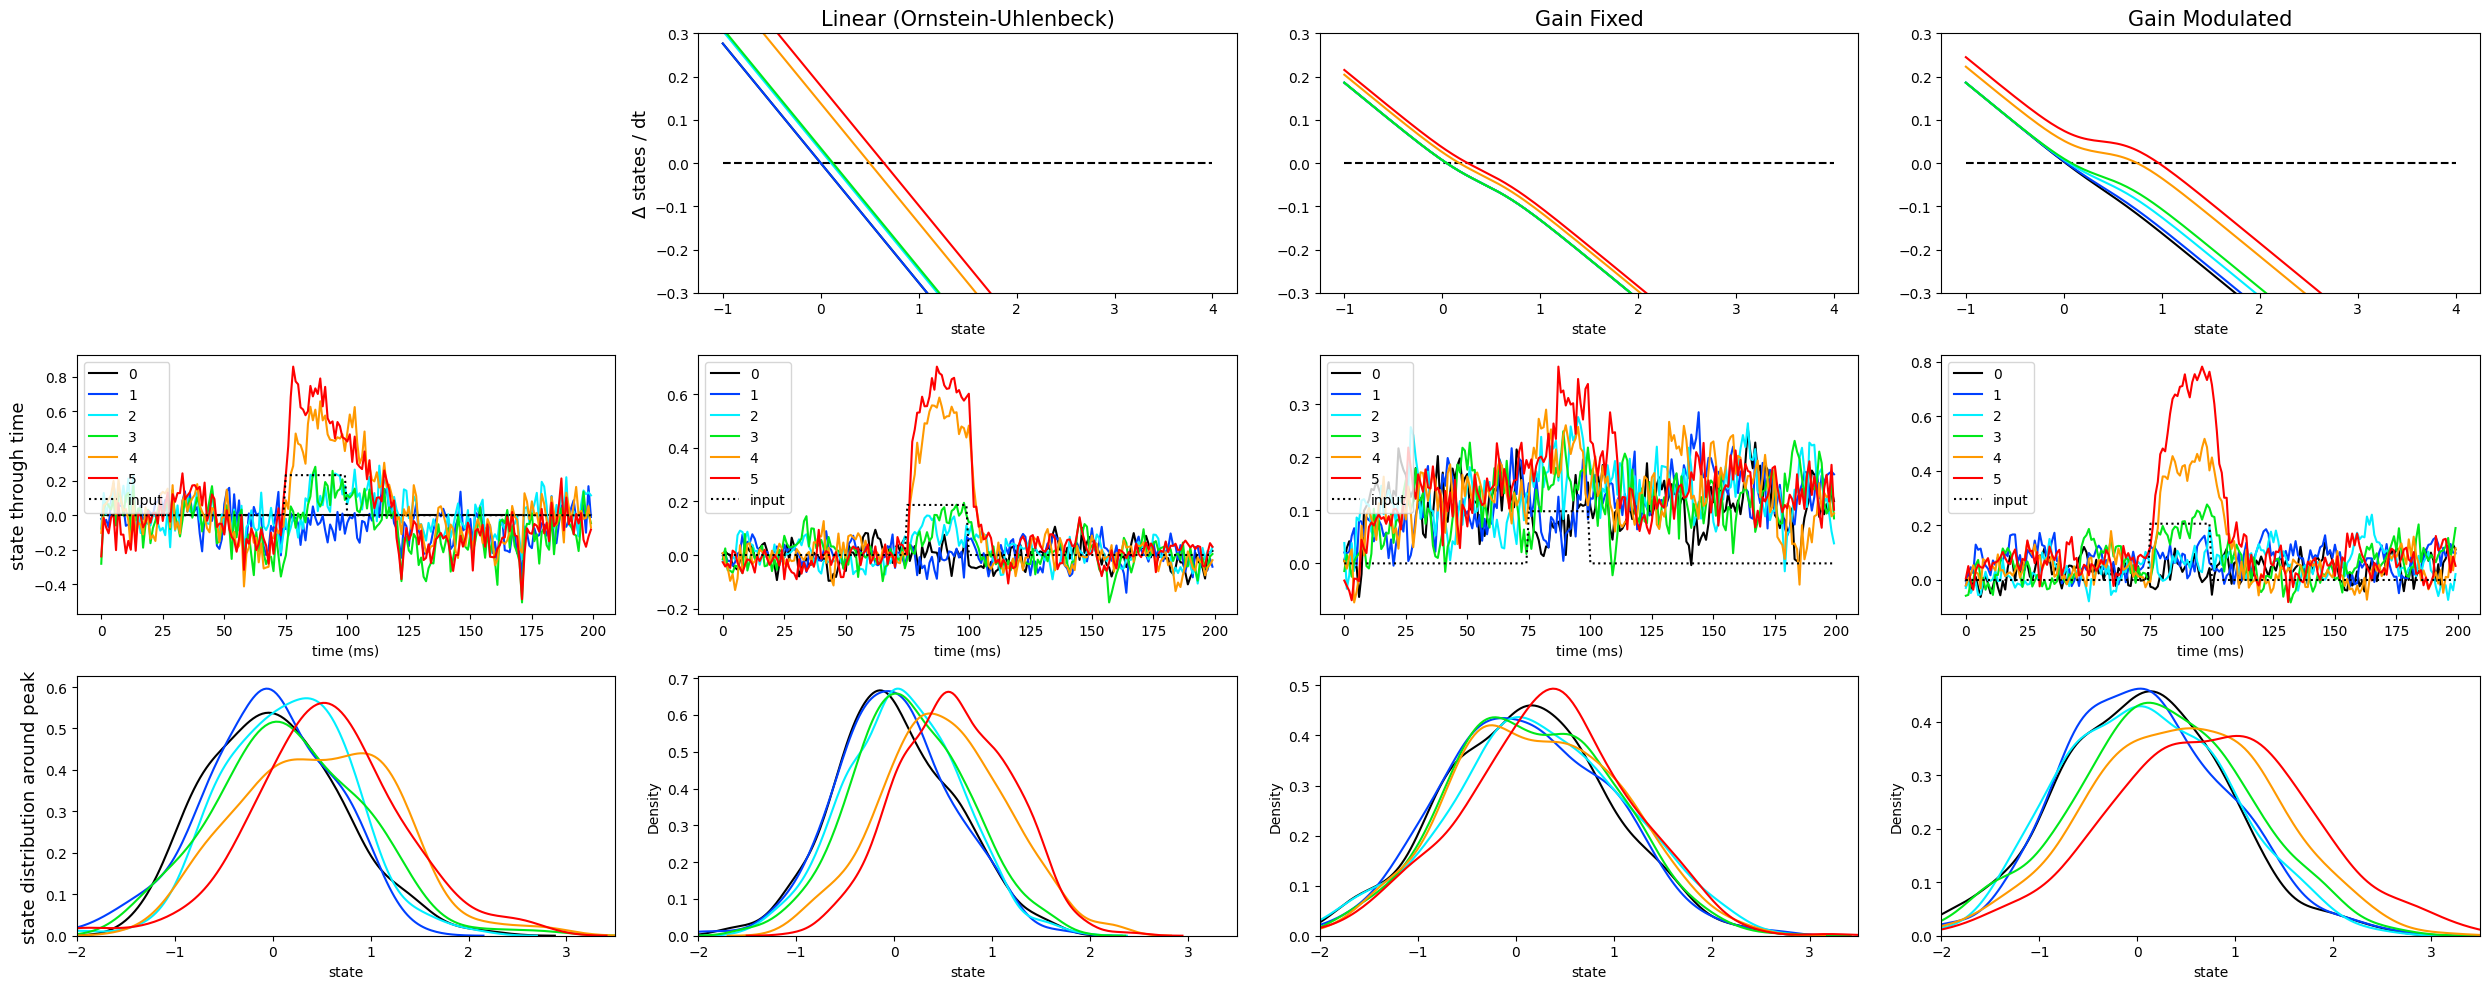

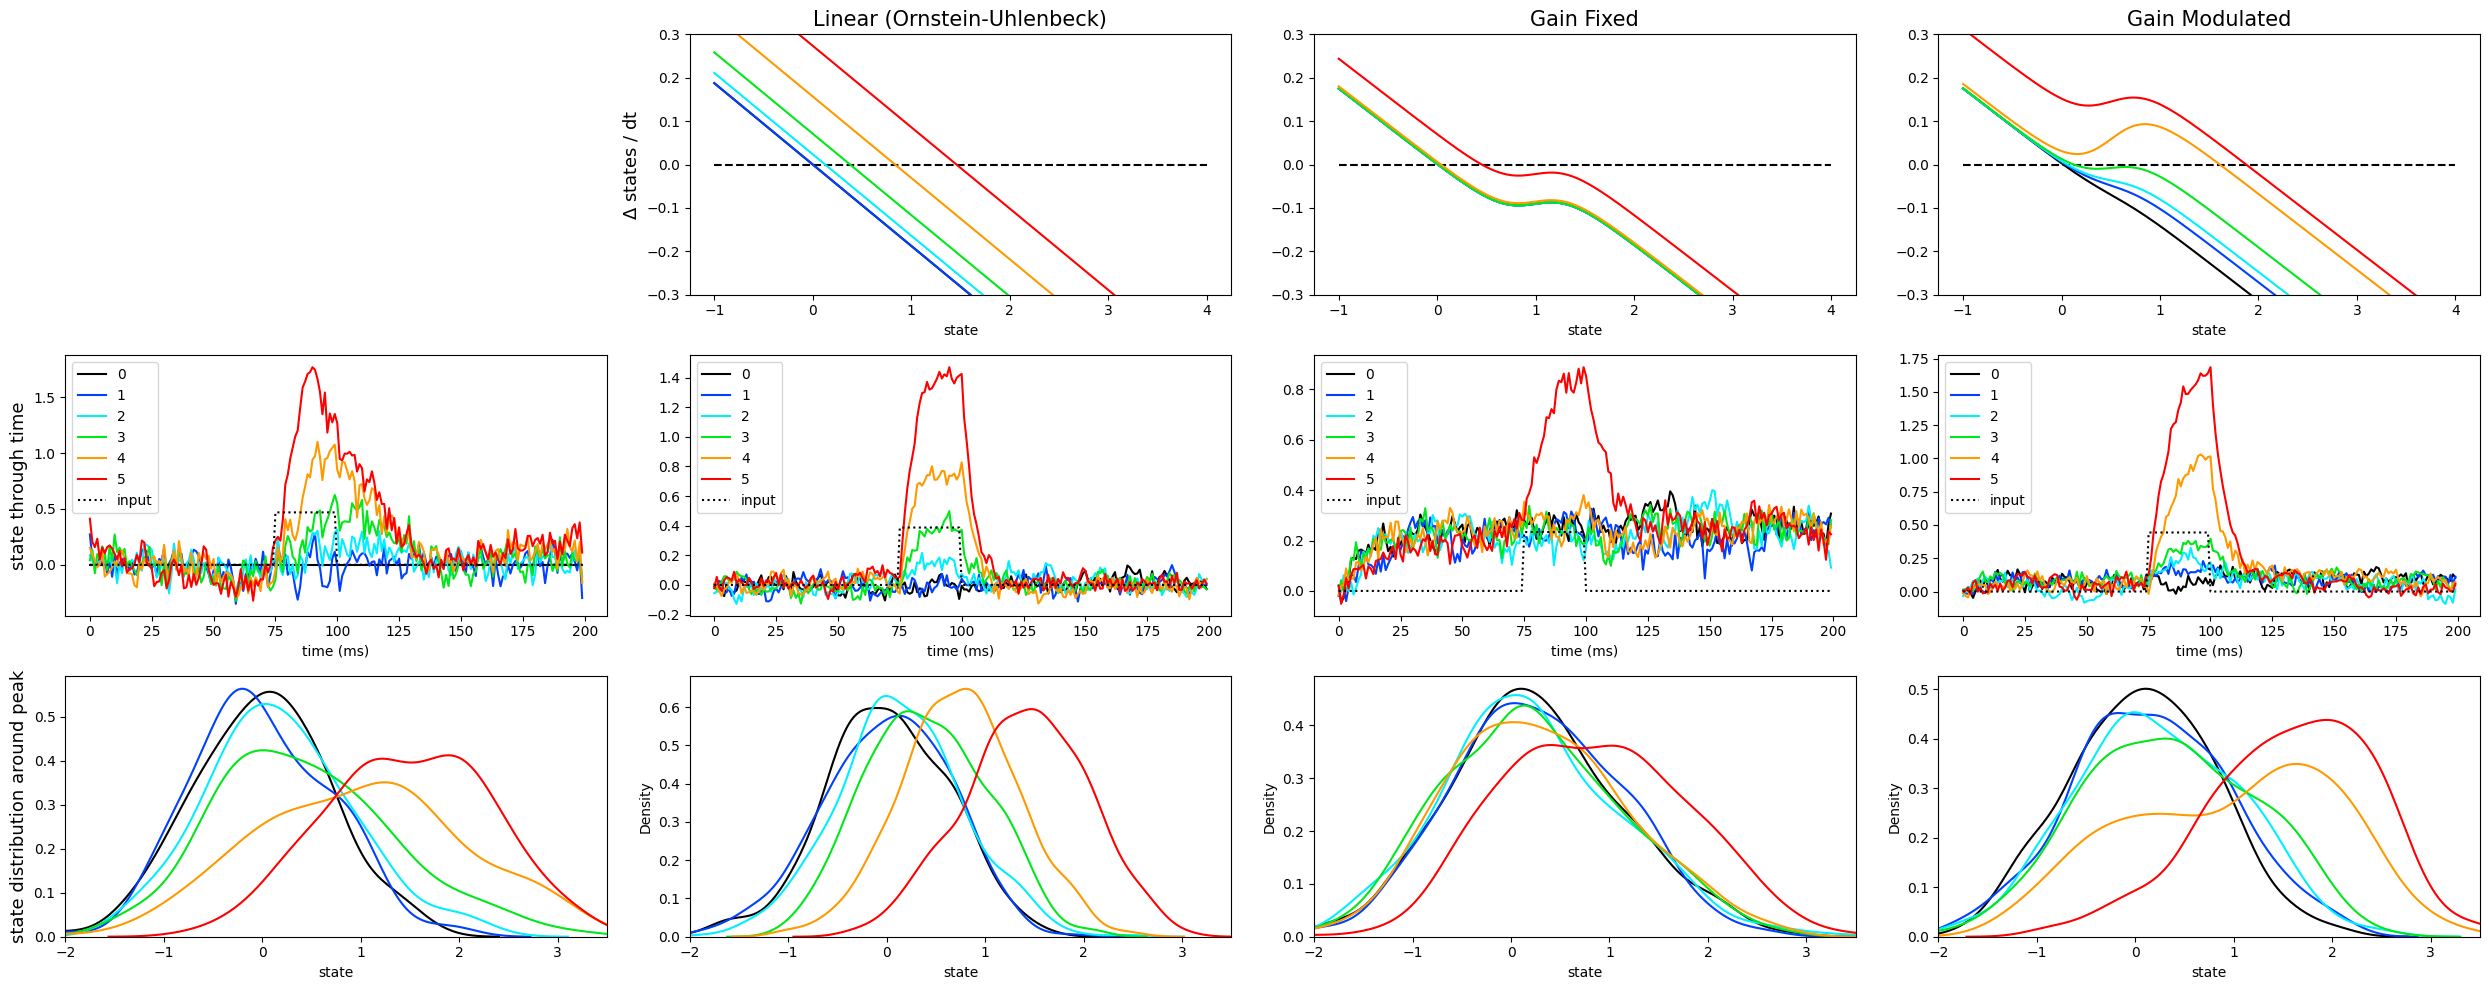

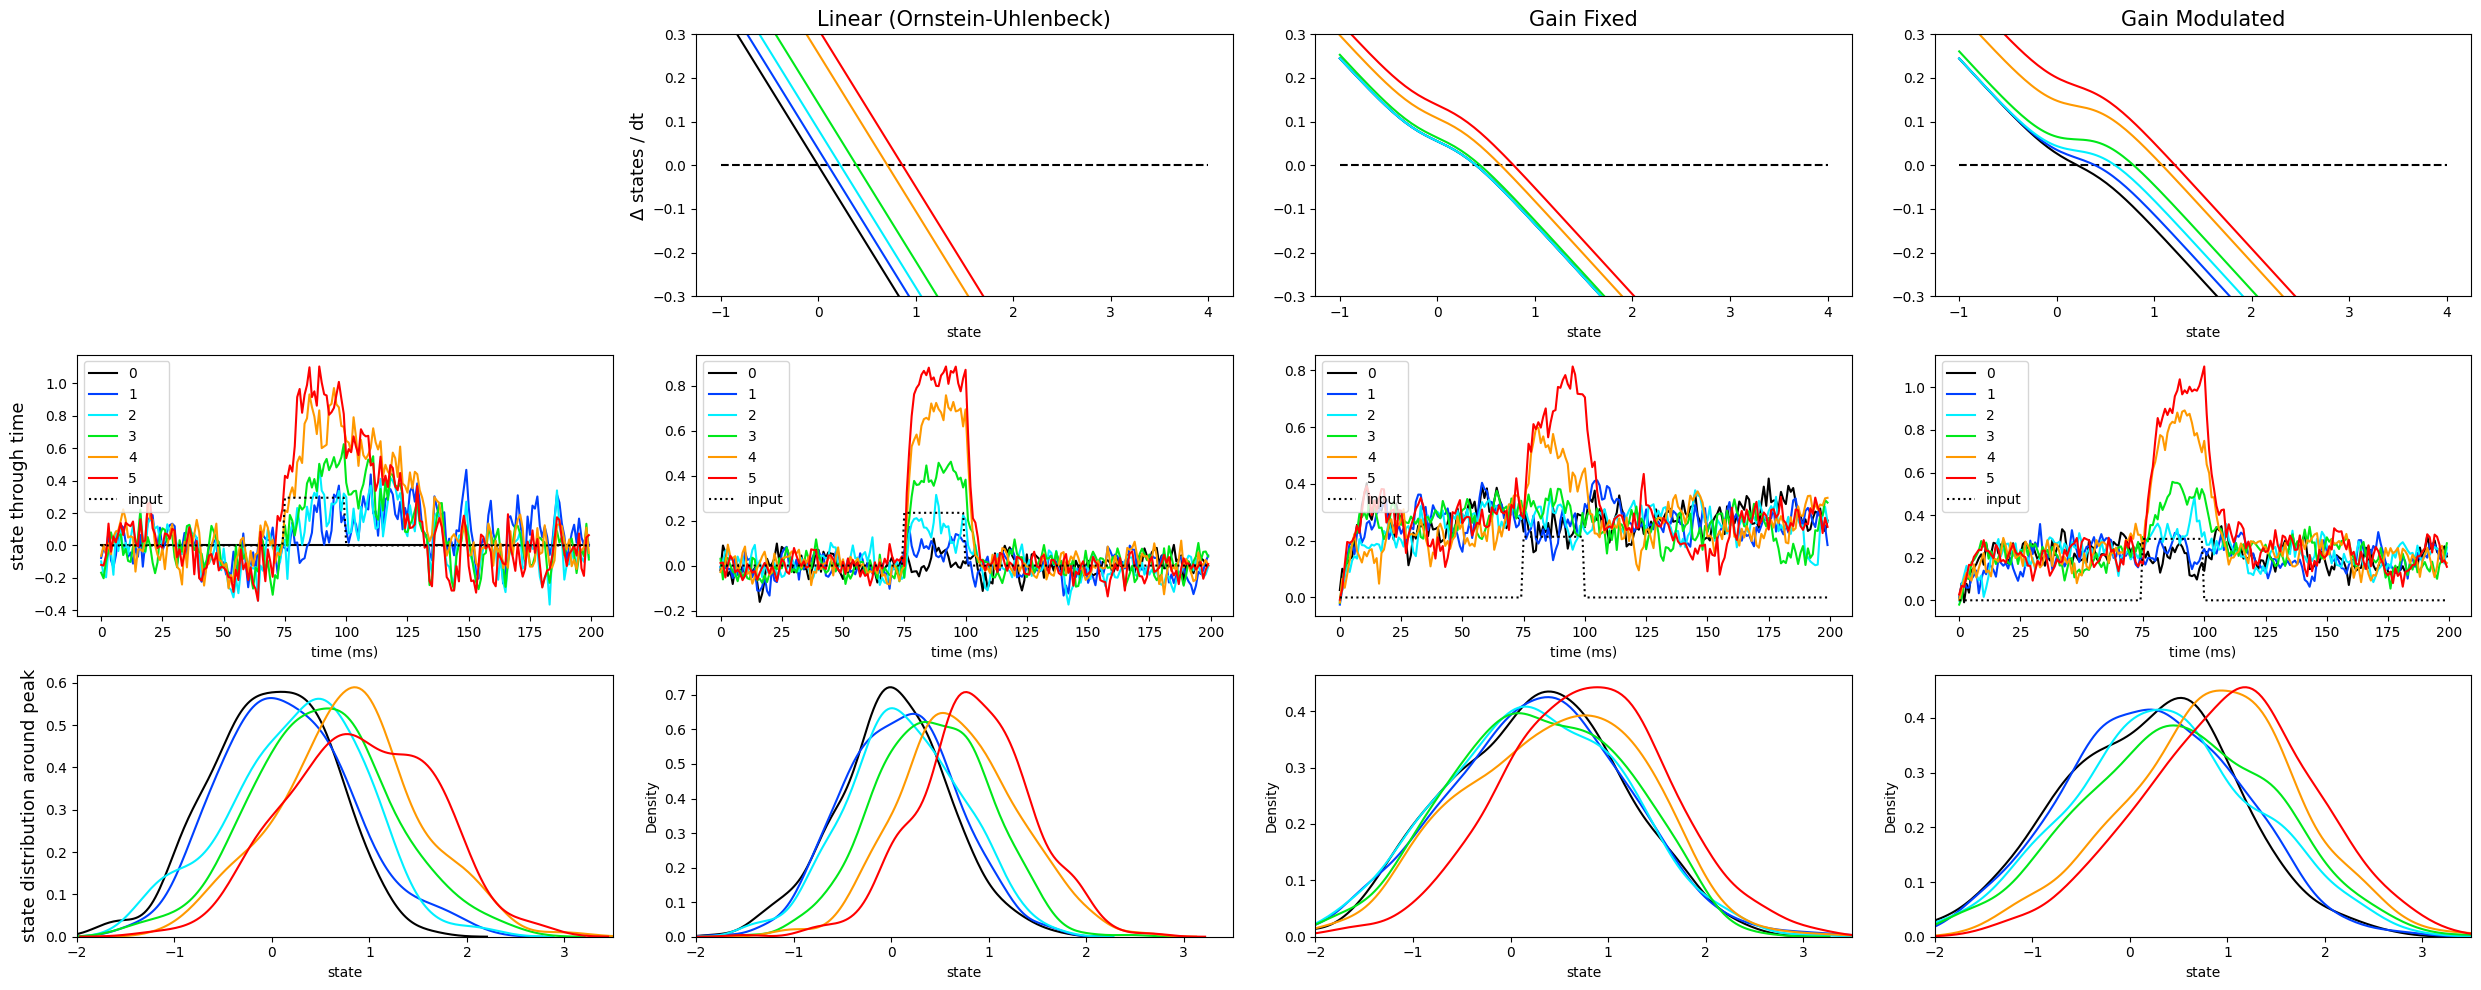

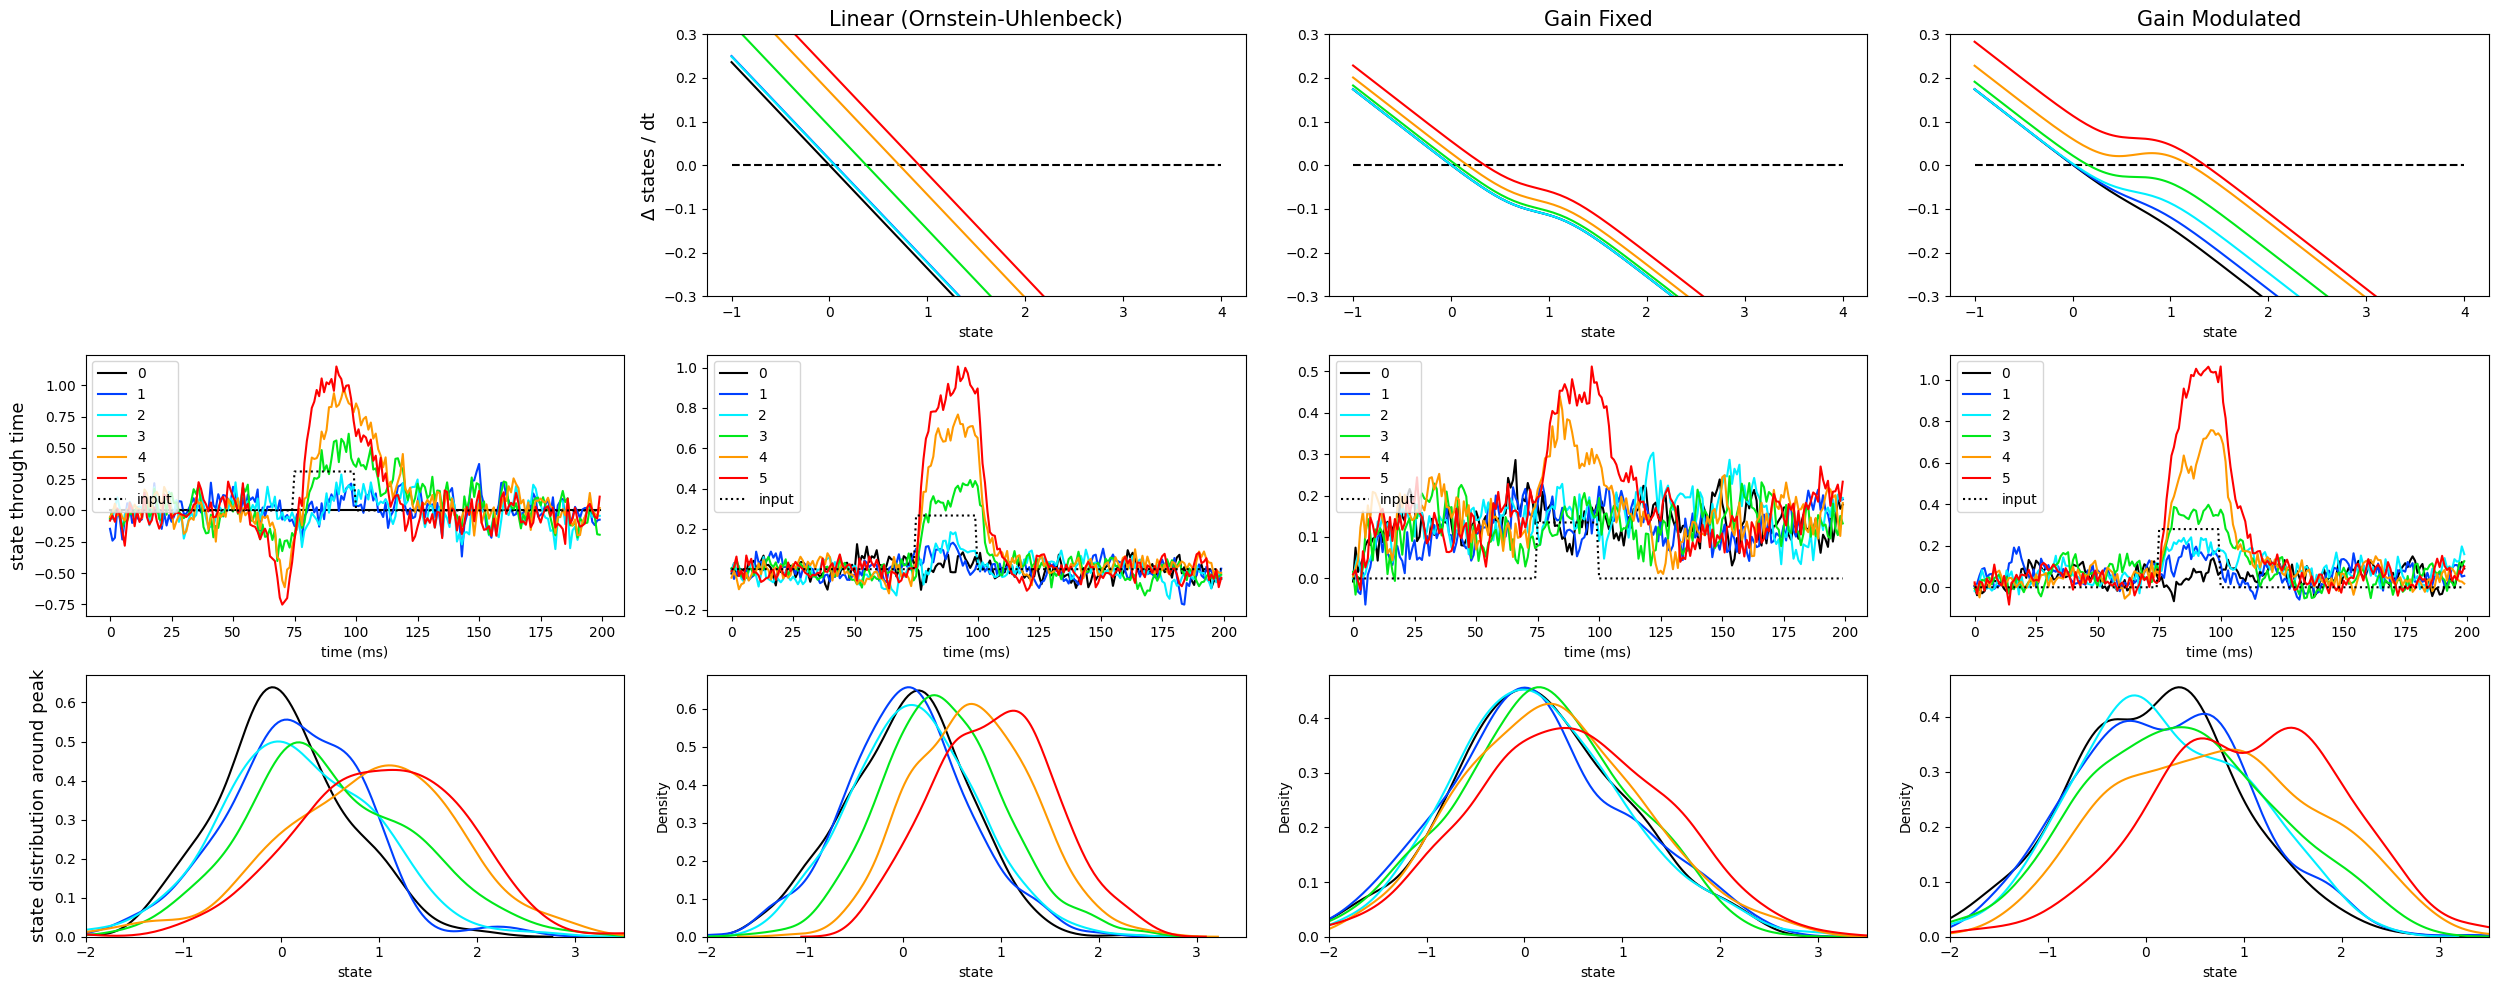

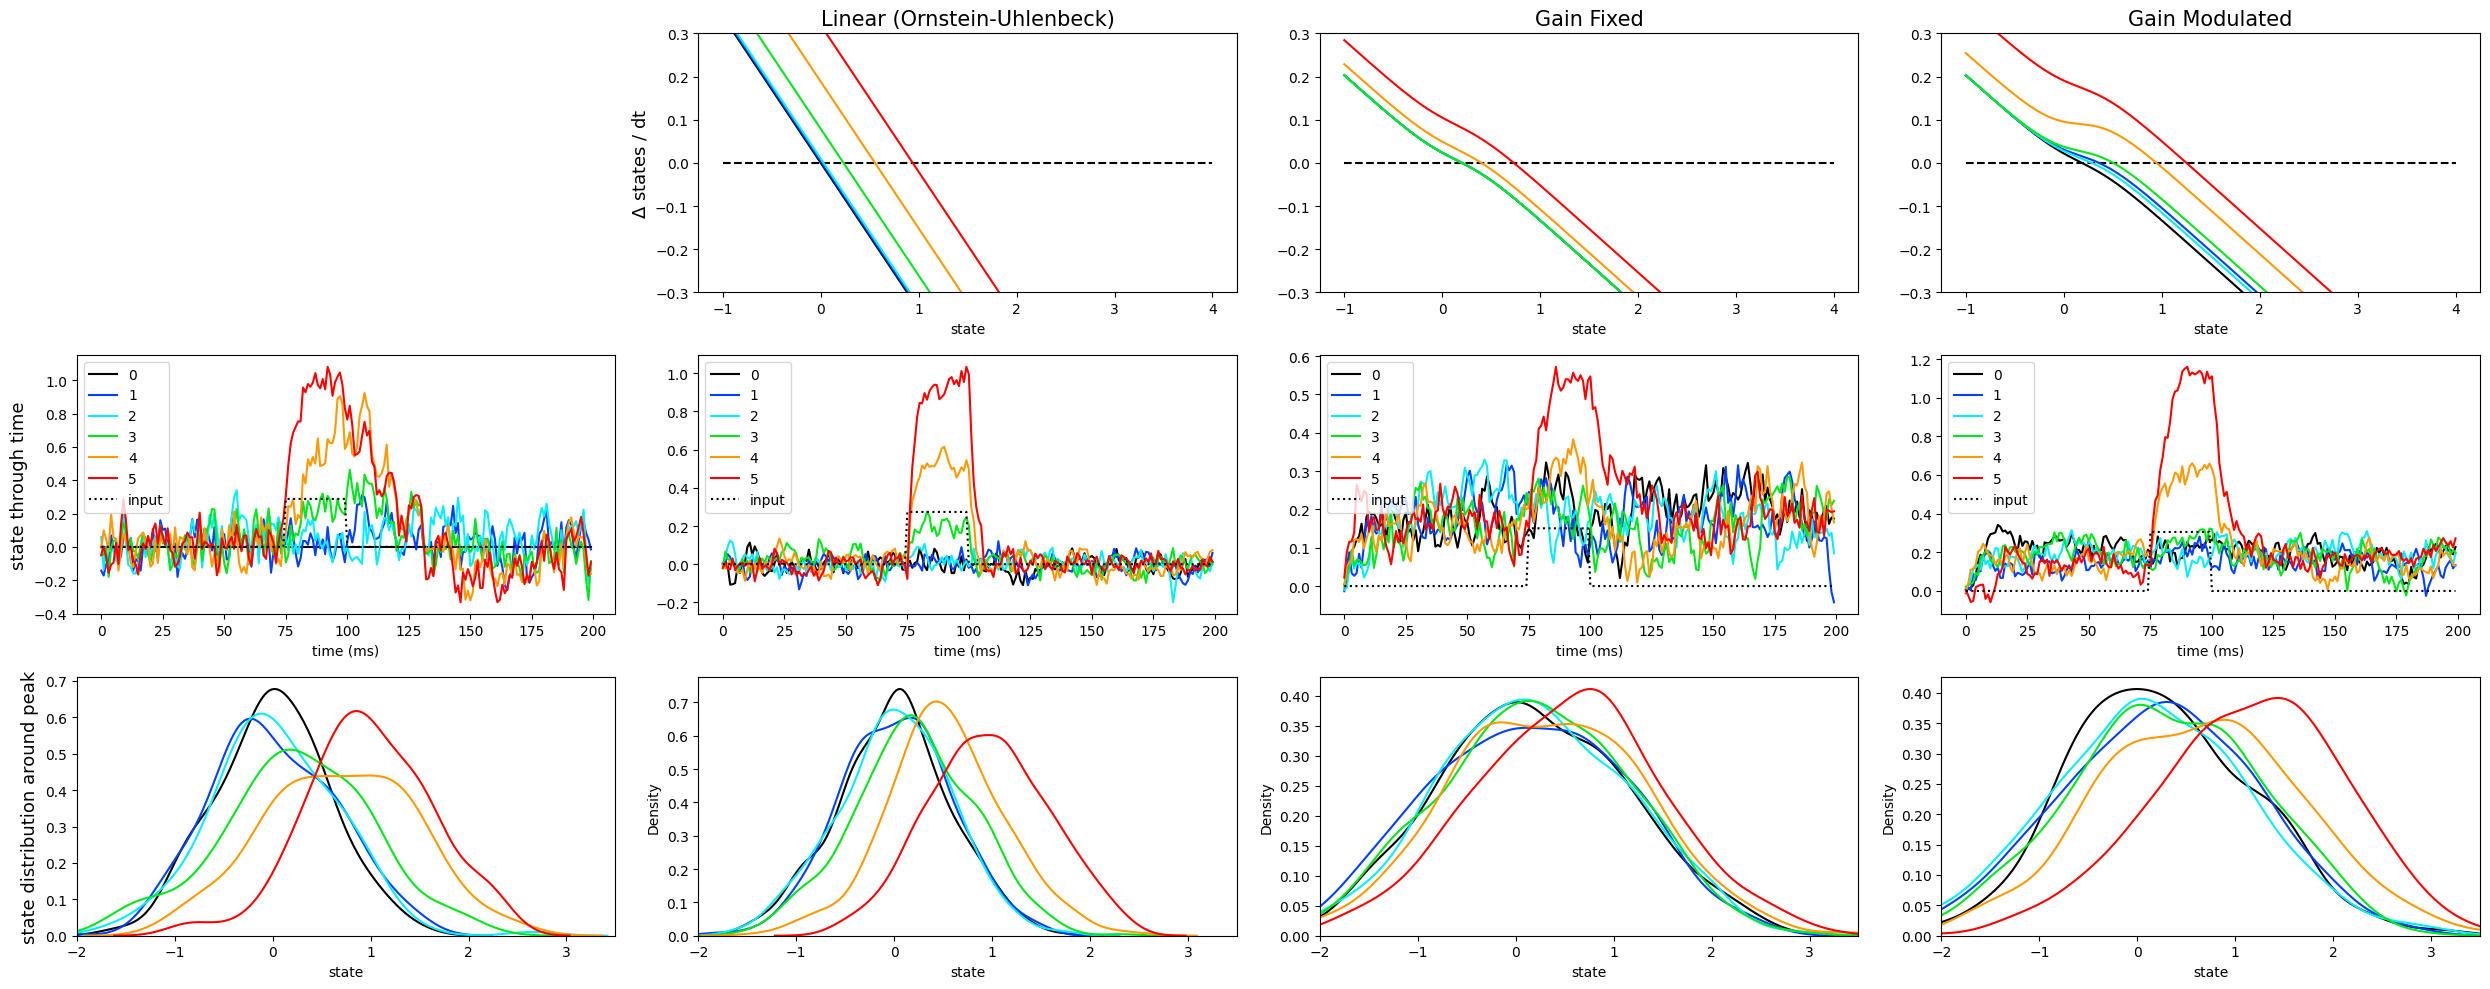

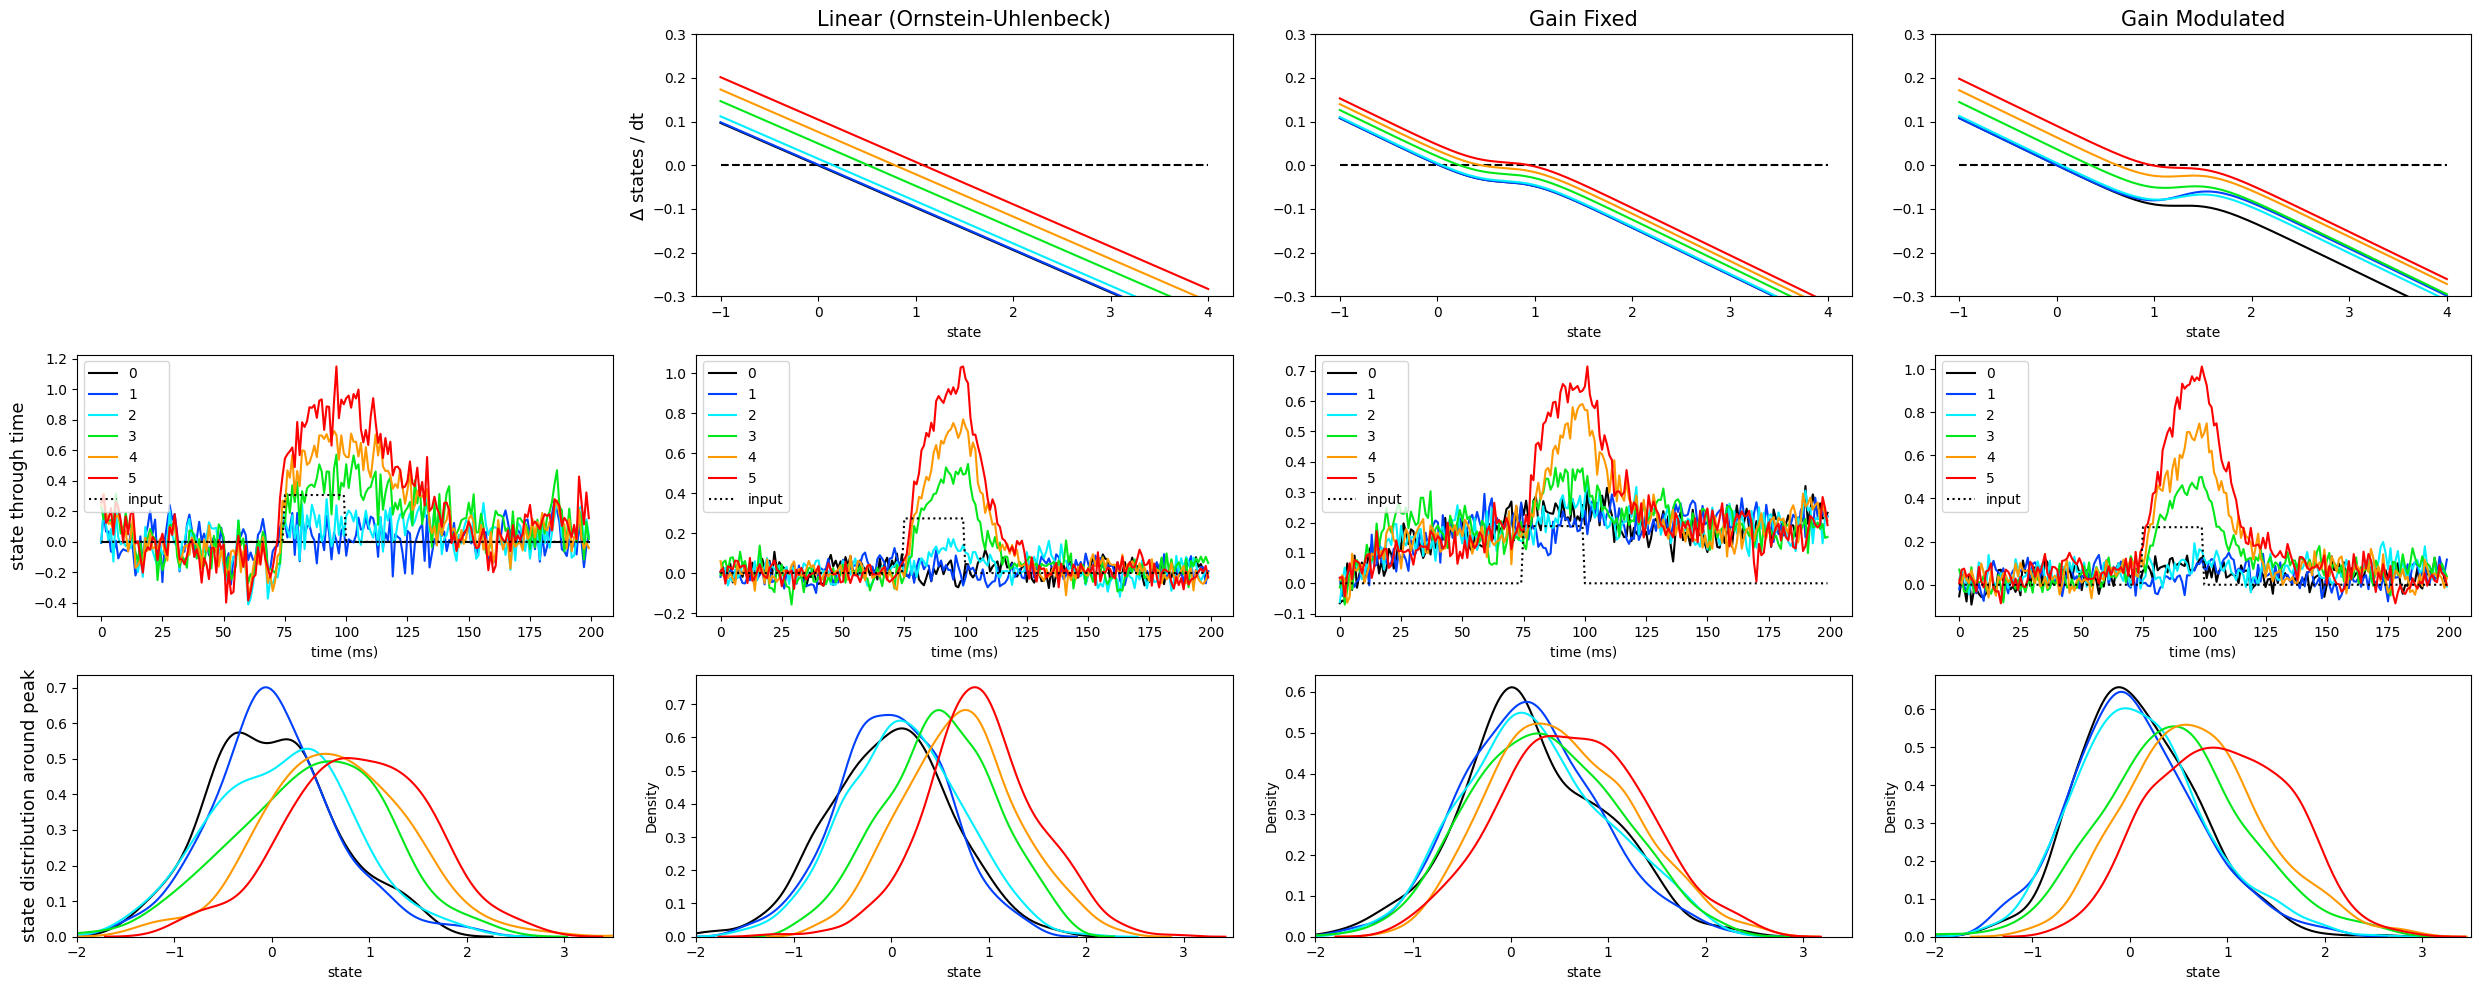

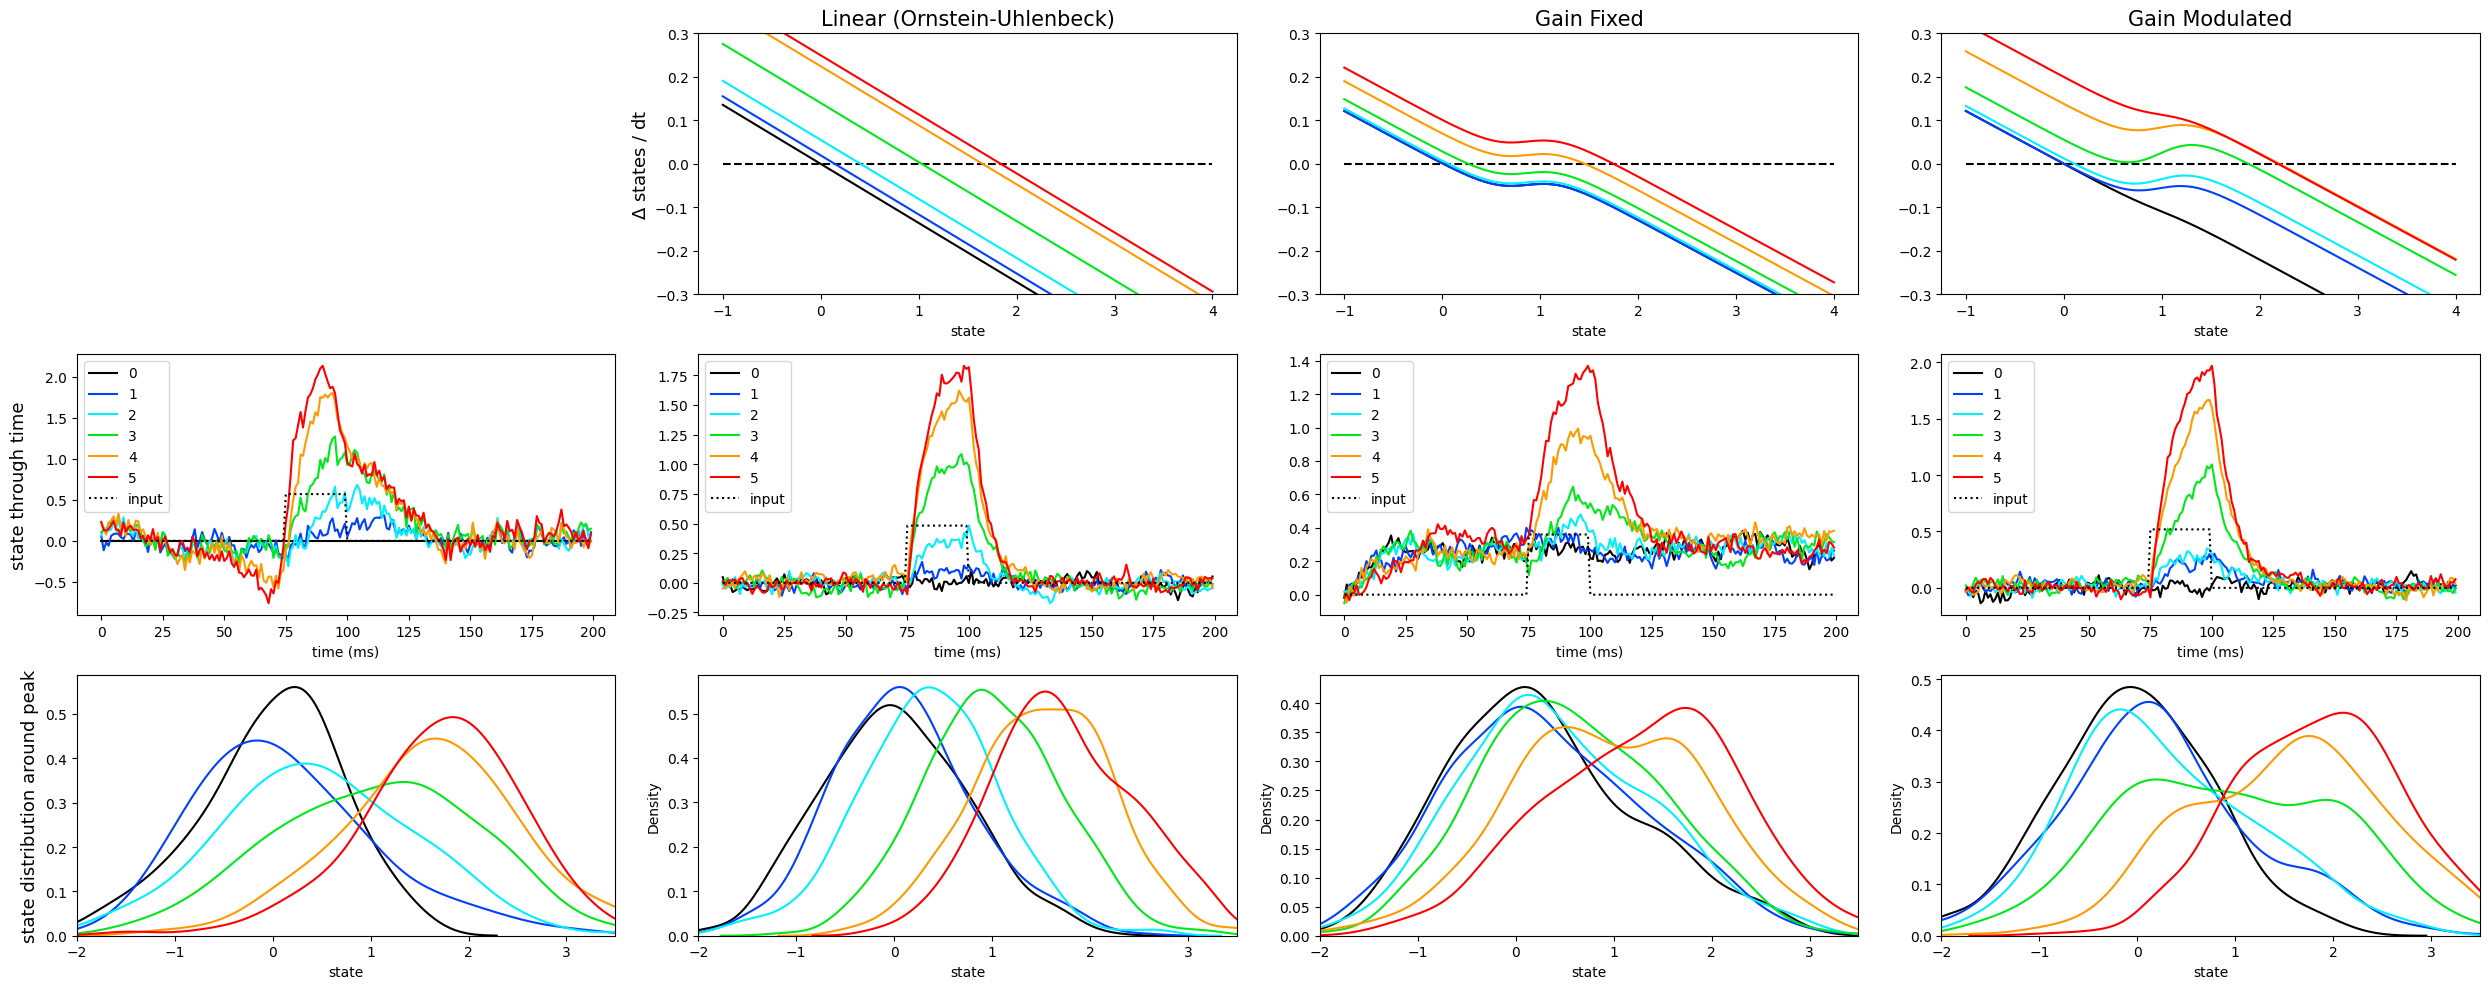

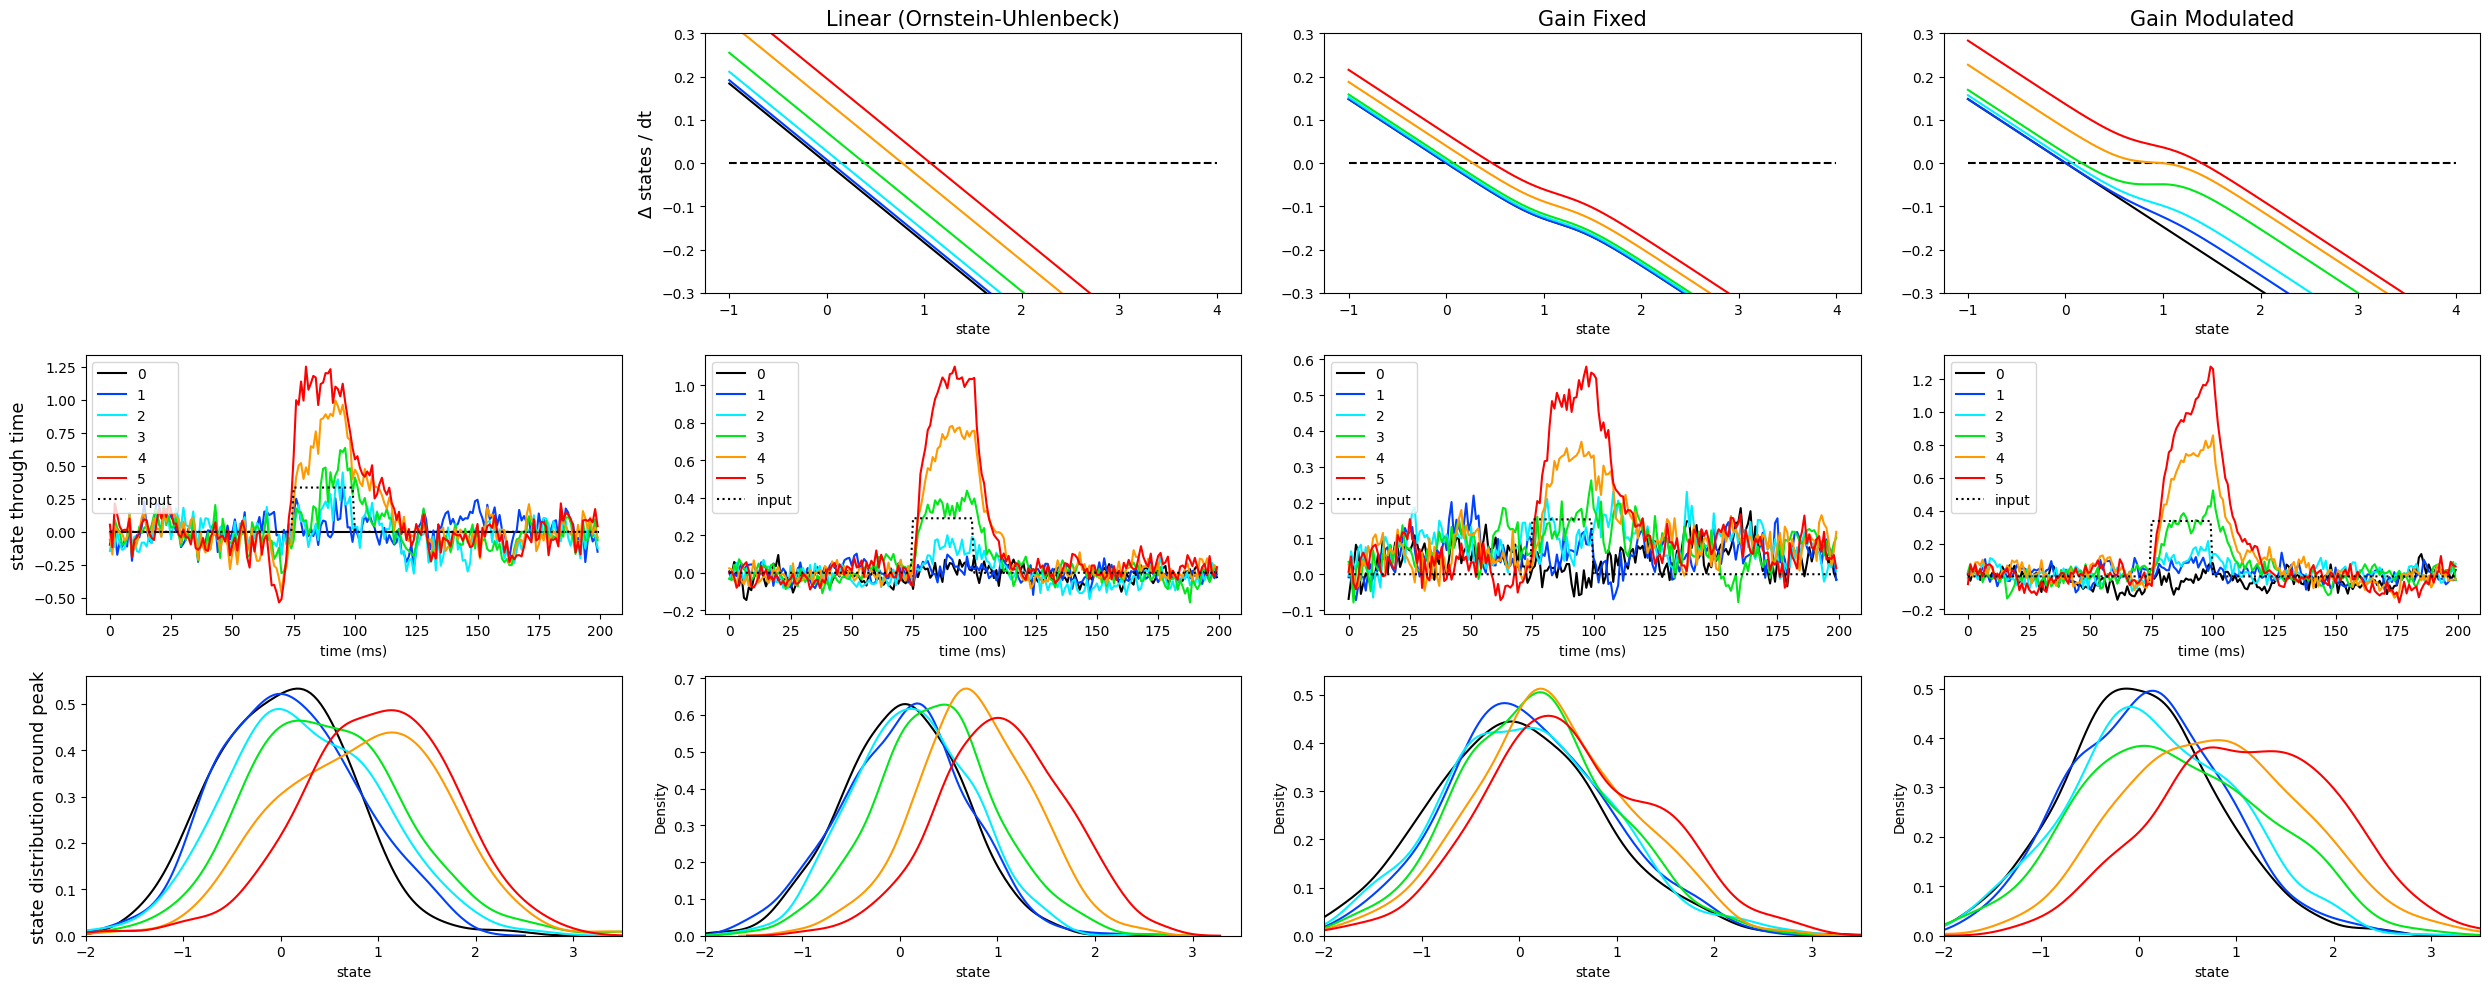

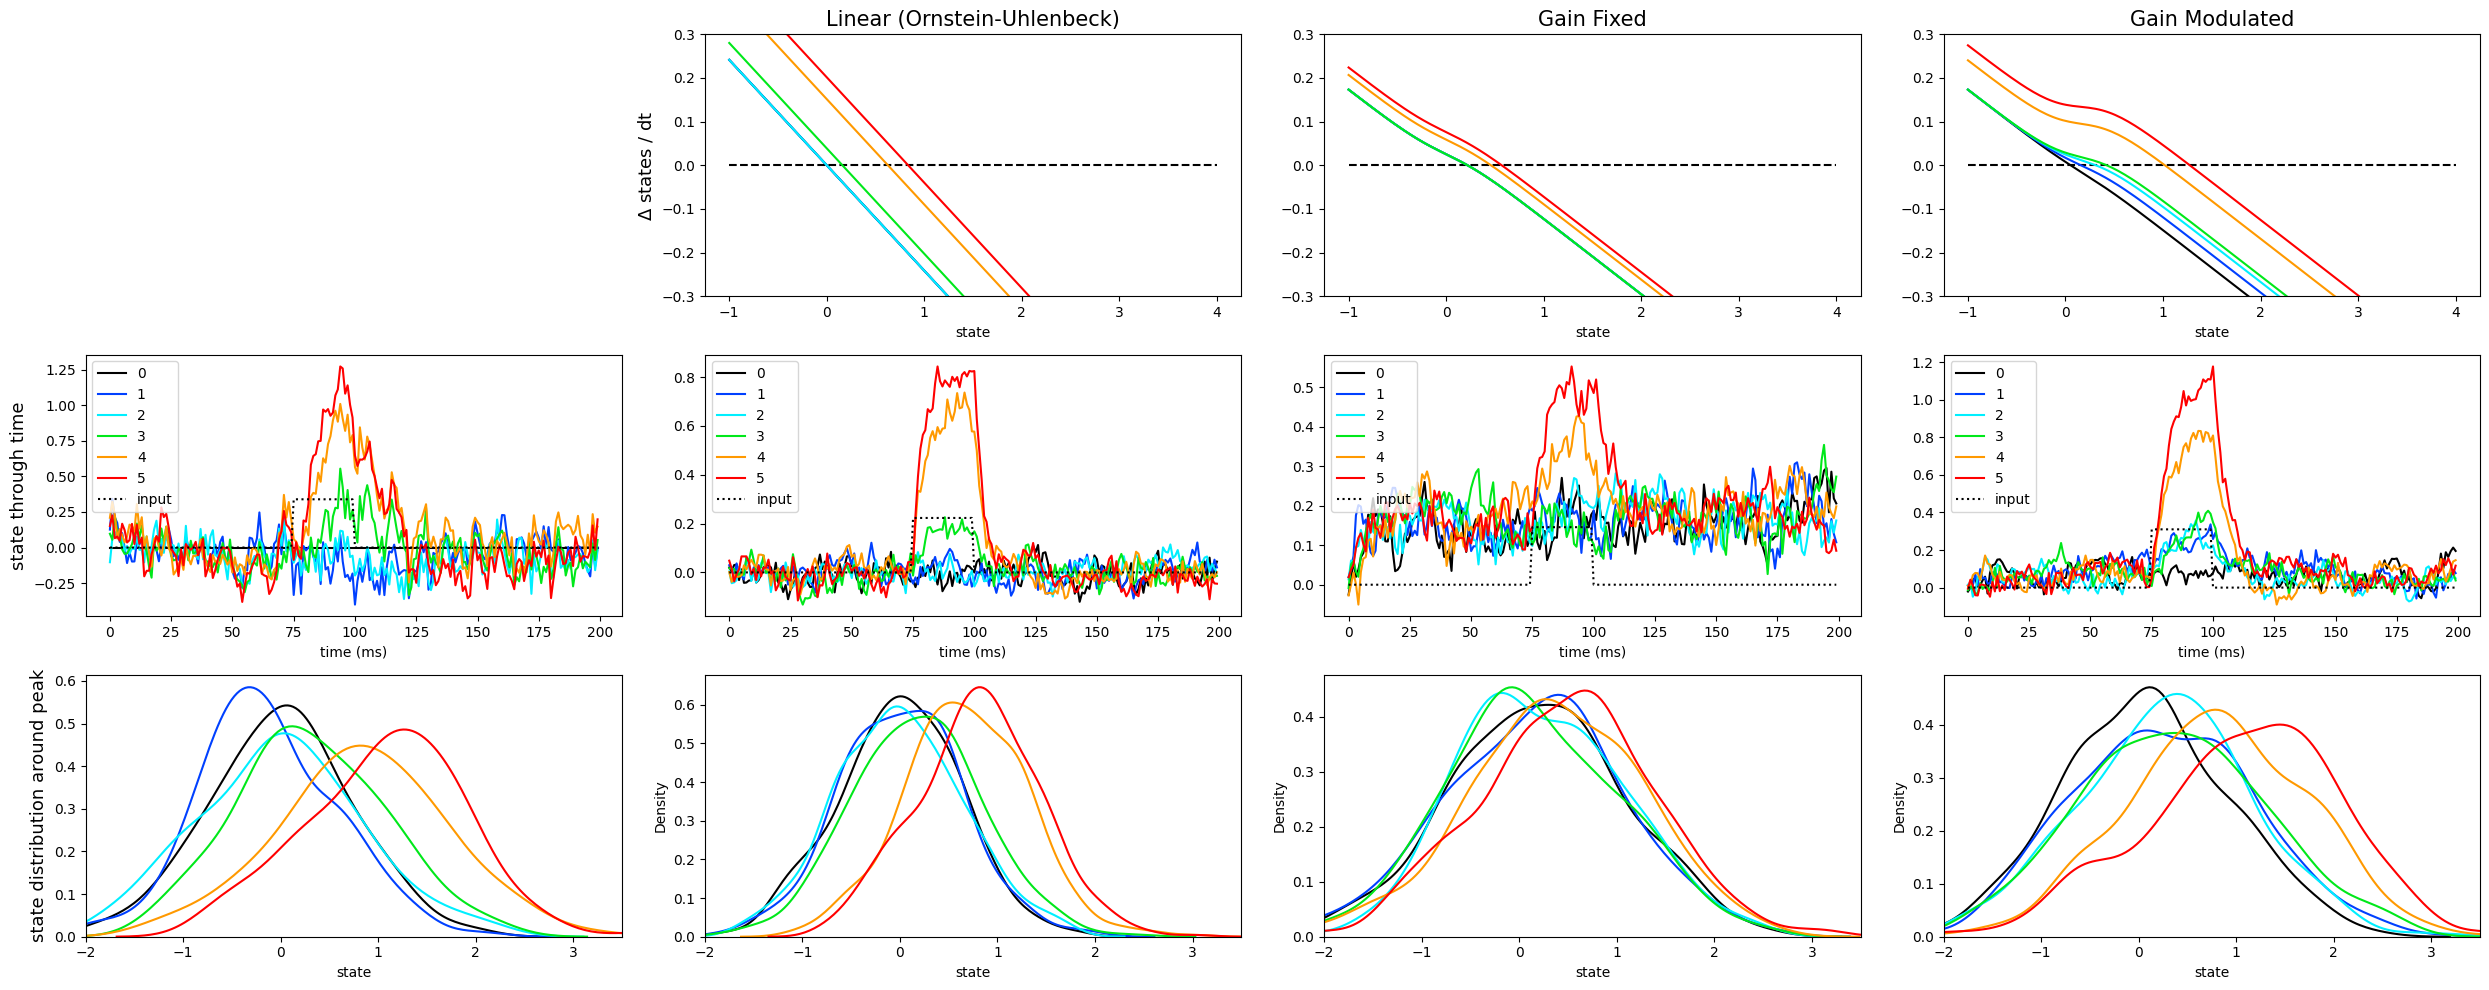

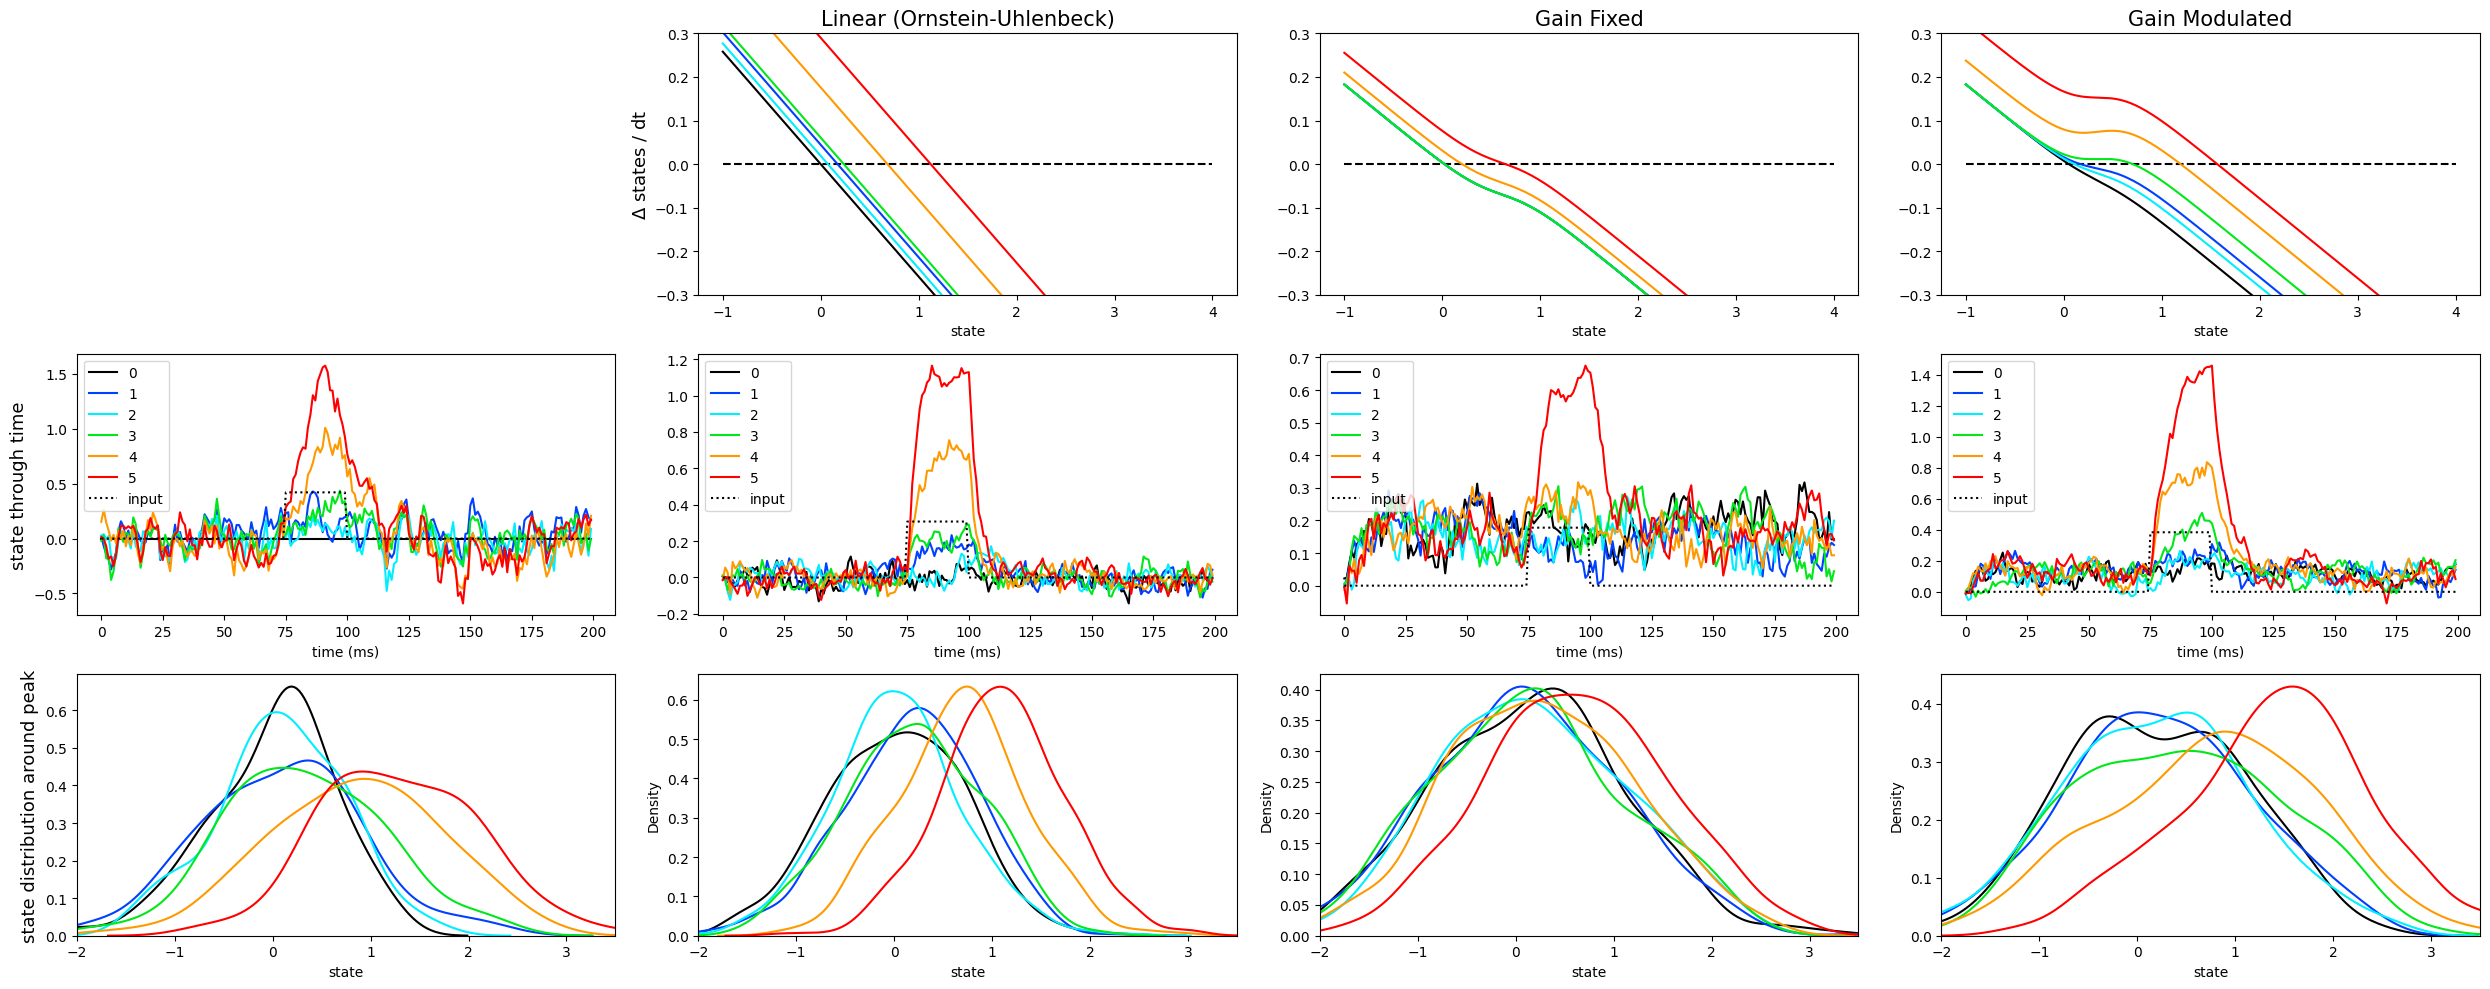

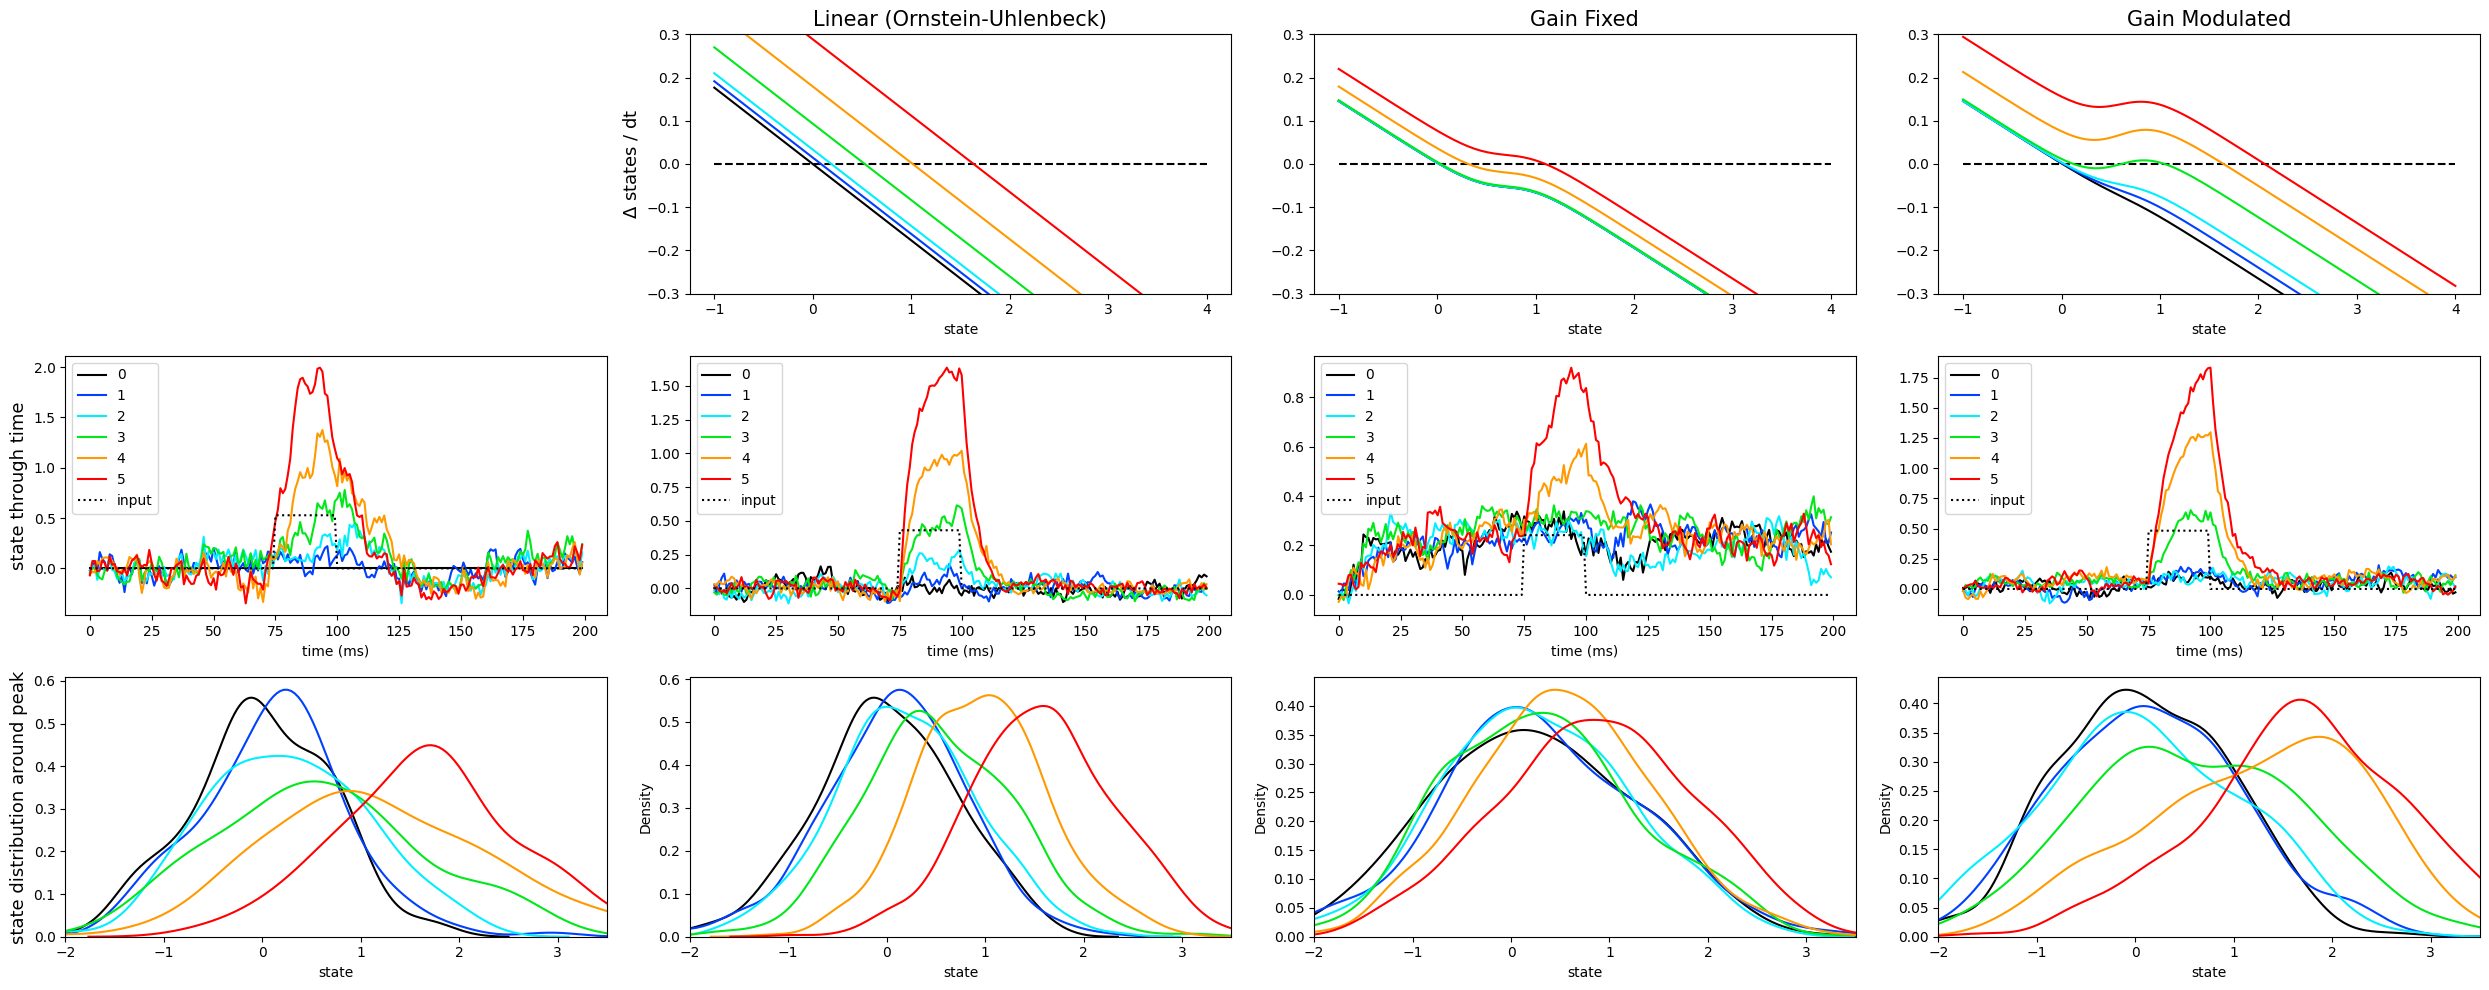

In [ ]:
task = 'Active'
file_path = f'Results_EEG_v9/{task}/late'
    
for part in tqdm(range(19,-1,-1)):
    
    data_ref = f'myEpochs_{task}/Epoch_{SubIDs[part]}-epo.fif'
    epochs_file = cwd.parents[0] / data_ref
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        state_train = upp.STG(epochs_file, tmin=300, tmax=500)
        n_categories = len(list(state_train.keys()))
        categories = list(range(n_categories))

    # Input definition (same for all categories & trials)
    one_input = np.concatenate((np.zeros(75), np.ones(25), np.zeros(150)))
    input_train = {cat: np.stack([one_input for _ in range(state_train[cat].shape[0])]) for cat in categories}
    
    n_categories = len(list(state_train.keys()))
    categories = list(range(n_categories))

    # ---- Fit StratifiedLinear ----
    fixed_params = ['w0'] if n_categories == 7 else ['w0', 'w6']
    linear = upp.model.StratifiedLinear_kalman(tau=10, process_noise=0.2, measure_noise=0.2)
    linear.fit(
        state_series=state_train,
        input_series=input_train,
        init_params=[9, 0.1, 0.1, *[0]*7],
        bounds=[(1, 25), (0.01, 1), (0.01, 1)] + [(0, 1)]*7,
        fixed_params=fixed_params,
        feedback=False)
    linear.save_params(f'{file_path}/LinearModel_part{part}_params')

    # ---- Fit StratifiedGainModul  ----
    gainmodul = upp.fitting_tools.clever_fit_gainmodul(pinit = None, state_train = state_train, input_train = input_train, n_loops = 2, t1=75, t2=100, t3=125)
    gainmodul.save_params(f'{file_path}/GainModulatedModel_part{part}_params')

    # ---- Fit StratifiedNonLinear1  ----
    mean_gain = np.mean([getattr(gainmodul, f"g{i}") for i in range(n_categories)])
    nonlinear = upp.model.StratifiedNonLinear1(tau=gainmodul.tau, process_noise=gainmodul.process_noise, measure_noise=gainmodul.measure_noise, gain=mean_gain, threshold=gainmodul.threshold, sharpness=5, **{f"w{i}": getattr(gainmodul, f"w{i}") for i in range(7)})
    nonlinear.fit(
                state_series={cat: state_train[cat][:,75:125] for cat in range(n_categories)},
                input_series={cat: input_train[cat][:,75:125] for cat in range(n_categories)},
                init_params=[nonlinear.tau, nonlinear.process_noise, nonlinear.measure_noise] + [getattr(nonlinear, f'w{i}')/2 for i in range(7)] + [mean_gain, nonlinear.threshold],
                bounds=[(1, 25), (0.01, 1), (0.01, 1)] + [(0, 1)]*7 + [(0, 0.5), (0, 2)],
                fixed_params=['tau', 'process_noise', 'measure_noise'] + [f'w{i}' for i in range(7)],
                feedback=False)
    nonlinear.save_params(f'{file_path}/GainFixedModel_part{part}_params')
    

    # ---- Run Simulations from the fitted models  ----
    n_trials = 500
    one_input = np.concatenate((np.zeros(75), np.ones(25), np.zeros(100)))
    input_series = np.stack([one_input for _ in range(n_trials)])
    measures_linear = {cat: linear.measure_simulations(initial_state = np.zeros(n_trials), input_series = input_series, signal_category = cat) for cat in categories}
    measures_nonlinear = {cat: nonlinear.measure_simulations(initial_state = np.zeros(n_trials), input_series = input_series, signal_category = cat) for cat in categories}
    measures_gainmodul = {cat: gainmodul.measure_simulations(initial_state = np.zeros(n_trials), input_series = input_series, signal_category = cat) for cat in categories}
    

    # ---- Plot Results  ----
    states = np.linspace(-1,4,150)
    conditions = [(0, 0), (1, 1), (1,2), (1,3), (1,4), (1,5)]
    labels = {cat: str(cat) for cat in range(n_categories)}
    
    plt.figure(figsize=(25, 10))
    
    # Define models and their corresponding measures
    models = [
        ("Linear (Ornstein-Uhlenbeck)", linear.core, measures_linear),
        ("Gain Fixed", nonlinear.core, measures_nonlinear),
        ("Gain Modulated", gainmodul.core, measures_gainmodul)
    ]
    
    
    # === TOP ROW: Δstate/dt plots ===
    for i, (title, model_func, _) in enumerate(models, start=1):
        plt.subplot2grid((9, 4), (0, i), rowspan=3)
        plt.plot([states[0], states[-1]], [0, 0], linestyle='--', color='black')
    
        for cond_ind, (input_value, signal_category) in enumerate(conditions):
            plt.plot(
                states,
                model_func(states, input_value * np.ones_like(states), signal_category) - states,
                color=colormap[cond_ind],
                label=labels[cond_ind]
            )
    
        plt.xlabel('state')
        if i == 1:
            plt.ylabel(r'$\Delta$ states / dt', fontsize=13)
        plt.ylim(-0.3,0.3)
        plt.title(title, fontsize=15)
    
    # === MIDDLE ROW: Time-series plots ===
    # Define all time-series datasets
    time_series_data = [
        ("Real Participant", state_train),
        ("Linear", measures_linear),
        ("Non-Linear", measures_nonlinear),
        ("Gain Modulation", measures_gainmodul)
    ]
    
    for i, (title, data_dict) in enumerate(time_series_data):
        plt.subplot2grid((9, 4), (3, i), rowspan=3)
    
        for cat in categories:
            mean_trace = (
                data_dict[cat][:, :200].mean(0)
                if title == "Real Participant"
                else data_dict[cat].mean(0)
            )
            plt.plot(mean_trace, color=colormap[cat], label=str(cat))
    
        ymin, ymax = plt.ylim()
        plt.plot(ymax * one_input / 4, color='black', linestyle=':', label='input')
    
        plt.xlabel('time (ms)')
        if i == 0:
            plt.ylabel('state through time', fontsize=13)
        # plt.title(title, fontsize=15)
        plt.legend(loc='upper left')
    
    # === BOTTOM ROW: KDE distributions ===
    t1, t2 = 90, 100
    xmin, xmax = -2, 3.5
    distribution_data = [
        ("Real Participant", state_train),
        ("Linear", measures_linear),
        ("Non-Linear", measures_nonlinear),
        ("Gain Modulation", measures_gainmodul)
    ]
    
    for i, (title, data_dict) in enumerate(distribution_data):
        plt.subplot2grid((9, 4), (6, i), rowspan=3)
    
        avgs = {cat: np.mean(data_dict[cat][:, t1:t2], -1).flatten() for cat in categories}
        for cat in categories:
            sns.kdeplot(data=avgs[cat], label=str(cat), color=colormap[cat])
    
        plt.xlim(xmin, xmax)
        plt.xlabel('state')
        if i == 0:
            plt.ylabel('state distribution around peak', fontsize=13)
        # plt.title(title, fontsize=15)
    
    plt.tight_layout()
    plt.savefig(f'{file_path}/AllModels_part{part}.png')
    plt.show()
